# Belief

Belief is a central concept in stochastic estimation and control.  In many real world problems, the exact state of the system $x \in \mathbb{R}^n$ is unknown, and thus considered a random variable.  We represent belief in state as a probability distribution $p(x)$.  With this statistical representation, we can reason about the most likely state (expectation) as well as a level of trust in it (confidence/uncertainty).  Many software packages provide statistical representations, but because belief is central to stochastic estimation, several common/useful builtins are included with `sia`, with the ability to integrate with other libraries (by subclassing `sia.Distribution`).  This example shows basic usage of the distributions.

In [1]:
# Import the libSIA python bindings and numpy
import pysia as sia
import numpy as np

# Import plotting helpers
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

# Set the generator instance seed for repeatability
generator = sia.Generator.instance()
generator.seed(10)

## 1D Parametric Distributions
These distributions $p(x|\theta)$ represent a random variable $x \in \mathbb{R}$ with a parameter set $\theta$.  Two common distributions are Gaussian $\mathcal{N}(x|\mu,\sigma^2)$ and Uniform $\mathcal{U}(x|a,b)$.
- `sia.Gaussian`.  Gaussians are the statistical equivalent of linear systems, i.e. the probabilities obey superposition.  They are fully represented by statistical parameters $\theta = \{\mu, \sigma^2\}$.  Due to linearity, they are often used in conjunction with linear systems.
- `sia.Uniform`.  Uniform distributions are useful as a prior belief for non-linear filters when we are completely uncertain about the initial state but have some idea of reasonable lower and upper bounds $\theta = \{a, b\}$.  In this case, all samples in the distribution are equally probable.  Another way to say this is the uniform distribution has the highest Shannon entropy out of possible distributions.

In this example we show a couple 1D parameterizations with their statistics.

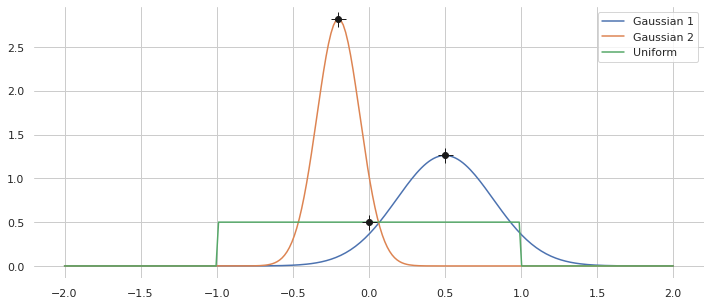

In [2]:
distributions = {
    "Gaussian 1": sia.Gaussian(mean=0.5, variance=0.1),
    "Gaussian 2": sia.Gaussian(mean=-0.2, variance=0.02),
    "Uniform": sia.Uniform(lower=-1.0, upper=1.0),
}
        
# Plot the probabilities
f, ax = plt.subplots(figsize=(12, 5))
sns.despine(f, left=True, bottom=True)

# Evaluate the probability using sia.Distribution.logProb(x)
x = np.linspace(-2, 2, 250)
for name, dist in distributions.items():
    
    # Helper to evaluate the probability for multiple samples
    prob = np.exp(sia.logProb1d(dist, x))
    plt.plot(x, prob, label=name)
    
    # Add dots for the distribution means
    mean = dist.mean()
    plt.plot(mean, np.exp(dist.logProb(mean)), ".k", ms=12)
    
    # Add plusses for the distribution modes
    mode = dist.mode()
    plt.plot(mode, np.exp(dist.logProb(mode)), "+k", ms=15)

plt.legend()
plt.show()

## n-D Parametric Distributions
Distributions in `sia` are defined over an $n$-dimensional state.  In this case we show examples of probabilities for 2D Gaussian distributions $\mathcal{N}(x|\mu,\Sigma)$, where $\mu$ is the mean and $\Sigma$ is the covariance.

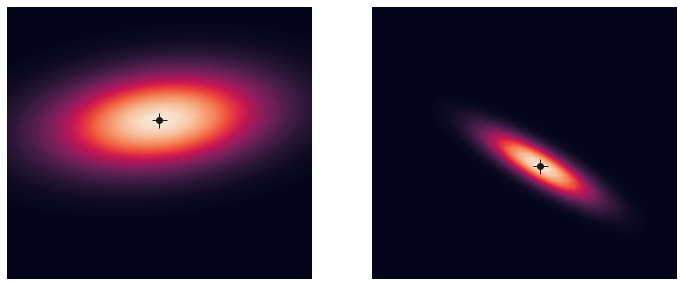

In [3]:
distributions = {
    "Gaussian 1": sia.Gaussian(mean=np.array([0, 0.5]),
                               covariance=np.array([[2, 0.2], [0.2, 0.5]])),
    "Gaussian 2": sia.Gaussian(mean=np.array([0.3, -0.5]),
                               covariance=np.array([[0.5, -0.3], [-0.3, 0.25]])),
}

# Plot the probabilities
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
ax = ax.flat
sns.despine(f, left=True, bottom=True)

# Evaluate the probability using sia.Distribution.logProb(x)
x = np.linspace(-3, 3, 51)
y = np.linspace(-3, 3, 51)
xx, yy = np.meshgrid(x, y)
i = 0
for name, dist in distributions.items():
    
    # Helper to evaluate the probability for multiple samples
    prob = np.exp(sia.logProb2d(dist, xx.flatten(), yy.flatten()))
    ax[i].contourf(xx, yy, np.reshape(prob, xx.shape), levels=100)
    
    # Add dots for the distribution means
    mean = dist.mean()
    ax[i].plot(mean[0], mean[1], ".k", ms=12)
    
    # Add plusses for the distribution modes
    mode = dist.mode()
    ax[i].plot(mode[0], mode[1], "+k", ms=15)
    
    ax[i].set_xlim((-3, 3))
    ax[i].set_ylim((-3, 3))
    ax[i].axis("off")
    
    i+=1

plt.show()

## Nonparameteric Distributions
Non-parameteric techniques are needed to represent more complex distributions, but suffer from increased complexity.  `sia` provides several native non-parameteric distributions, including samples and kernel densities.

### Particles
The `sia.Particles` distribution is simply a collection of $i = \{1,\ldots,N\}$ random samples $s_i \sim p(x)$.  The particle distribution is used by monte carlo-style algorithms such as the particle filter for representing complex distributions, e.g. non-Gaussian and potentially with multiple modes.

Each particle is represented by a sample and a corresponding weight, $\{s_i, w_i\}_i$, where $\sum_i w_i = 1$.  Unless explicitly specified, weights are chosen to be equal (uniform).  The class allows to choose whether the weights are used in the statistics computations.  The following table shows how the metrics are computes for samples $s_i$ and weights $w_i$.  Note that covariance is unbiased using Bessel's correction.

| Statistic      | Sample                                                        | Weighted                                                                       |
| -------------- | ------------------------------------------------------------- | ------------------------------------------------------------------------------ |
| Mean           | $$\mu =\frac{1}{N} \sum_i s_i$$                               | $$\mu = \sum_i w_i s_i$$                                                       |
| Mode           | Equivalent to mean                                            | $$s_i^* = \arg \max_i \{ w_i \}$$                                                |
| Covariance     | $$\Sigma = \frac{1}{N-1} \sum_i (s_i - \mu)(s_i - \mu)^\top$$ | $$\Sigma = \frac{1}{1 - \sum_i w_i^2} \sum_i w_i (s_i - \mu)(s_i - \mu)^\top$$ |

Below we show two particle distributions initialized from Gaussians.  One uses weights in the statistics compuations, the other does not.  Note in both cases the weights are uniform.

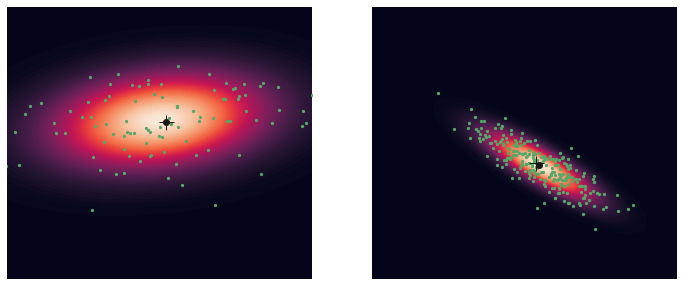

In [4]:
# Create the particle distributions by sampling the parametric Gaussians from before
samples = {
    "Gaussian 1": sia.Particles.init(distributions["Gaussian 1"], 
                                     num_particles=100,
                                     weighted_stats=False),
    "Gaussian 2": sia.Particles.init(distributions["Gaussian 2"], 
                                     num_particles=250,
                                     weighted_stats=True),
}

# Plot the probabilities
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
sns.despine(f, left=True, bottom=True)

# Add the samples to the density plots for the parameteric distributions
i = 0
for name, dist in distributions.items():
    
    # Helper to evaluate the probability for multiple samples
    prob = np.exp(sia.logProb2d(dist, xx.flatten(), yy.flatten()))
    ax[i].contourf(xx, yy, np.reshape(prob, xx.shape), levels=100)
    
    # Add scatter plots for the sample distributions
    sample = samples[name]
    ax[i].scatter(sample.values()[0, :], sample.values()[1, :], s=5, color="g")
    
    # Adds dots for the sample distribution means
    mean = sample.mean()
    ax[i].plot(mean[0], mean[1], ".k", ms=12)
    
    # Adds plusses for the sample distribution modes
    mode = sample.mode()
    ax[i].plot(mode[0], mode[1], "+k", ms=15)
    
    ax[i].set_xlim((-3, 3))
    ax[i].set_ylim((-3, 3))
    ax[i].axis("off")
    
    i+=1

plt.show()

### Kernel density estimators

The `sia.KernelDensity` distribution is a specialization of the particle distribution that builds local kernels around each particle.  This smooths the log probability, improves sampling, and mode finding.  The log probability for the multivariate kernel density is 
$$
\log f(x) = \log \sum_i^N w_i K_H(x-s_i).
$$
The function $K_H$ is a scaled kernel
$$
K_H(x) = \frac{1}{|H|} K(H^{-1} x)
$$
with bandwidth matrix $H > 0$ and kernel function $K(x)$.  Available kernel functions include the uniform, Gaussian, and Epanechnikov kernels.  The bandwidth $H$ affects the smoothing, with higher values increases the smoothing.  By default, the Scott's generalized rule of thumb is used to find the bandwidth.  Bandwidth can also be user specified.

This example shows several kernel densities for samples drawn from the standard normal distribution.

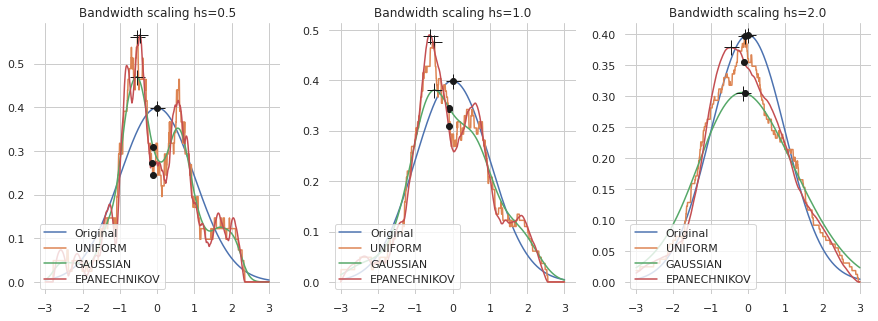

In [5]:
# Test cases
Nsamples = 100
bandwidths = [0.5, 1.0, 2.0]
kernels = [sia.Kernel.UNIFORM, sia.Kernel.GAUSSIAN, sia.Kernel.EPANECHNIKOV]

# Define the standard normal and sample from it
original = sia.Gaussian(mean=0, variance=1)
sample = sia.Particles.init(original, Nsamples)

# Plot the 1D kernel densities
ncols = len(bandwidths)
f, ax = plt.subplots(nrows=1, ncols=ncols, figsize=(15, 5))
sns.despine(f, left=True, bottom=True)

x = np.linspace(-3, 3, 1001)
for i in range(ncols):
    for j in range(len(kernels) + 1):
        if j == 0:
            dist = original
            name = "Original"
        else:
            # Create a kernel density and set the bandwidth scaling
            dist = sia.KernelDensity(sample, 
                                     type=kernels[j - 1], 
                                     mode=sia.KernelDensity.SCOTT_RULE,
                                     bandwidth_scaling=bandwidths[i])
            name = kernels[j - 1].name
            
        # Helper to evaluate the probability for multiple samples
        prob = np.exp(sia.logProb1d(dist, x))
        ax[i].plot(x, prob, label=name)
    
        # Add dots for the distribution means
        mean = dist.mean()
        ax[i].plot(mean, np.exp(dist.logProb(mean)), ".k", ms=12)
    
        # Add plusses for the distribution modes
        mode = dist.mode()
        ax[i].plot(mode, np.exp(dist.logProb(mode)), "+k", ms=15)
        ax[i].legend(loc="lower left")
        ax[i].set_title("Bandwidth scaling hs={}".format(bandwidths[i]))
        
plt.show()

Support for multidimensional kernel densities is provided, although KDEs are known to suffer from the curse of dimensionality.  As the state dimension increases, they become increasingly less useful.  This example shows kernel densities for samples drawn from a 2D Gaussian, this time using Scott's rule of thumb for the bandwidth.

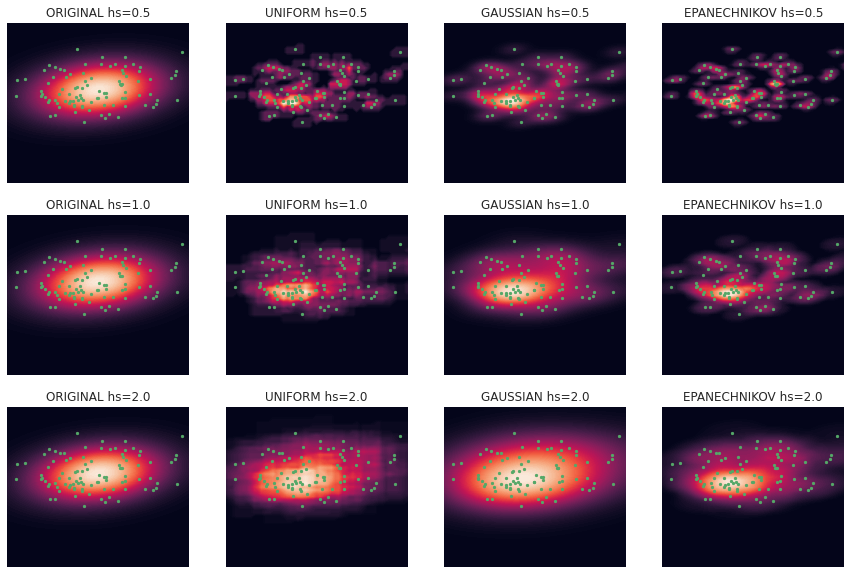

In [6]:
# Define the 2D original density
original = sia.Gaussian(mean=np.array([0, 0.5]),
                        covariance=np.array([[2, 0.2], [0.2, 0.5]]))
sample = sia.Particles.init(original, Nsamples)


# Plot the 2D probability densities
nrows = len(bandwidths)
ncols = len(kernels) + 1
f, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))
sns.despine(f, left=True, bottom=True)

for i in range(nrows):
    for j in range(ncols):
        if j == 0:
            dist = original
            name = "ORIGINAL"
        else:
            # Create a kernel density and set the bandwidth scaling
            dist = sia.KernelDensity(sample, 
                                     type=kernels[j - 1], 
                                     mode=sia.KernelDensity.SCOTT_RULE,
                                     bandwidth_scaling=bandwidths[i])
            name = dist.getKernelType().name
            
        # Helper to evaluate the probability for multiple samples
        prob = np.exp(sia.logProb2d(dist, xx.flatten(), yy.flatten()))
        ax[i, j].contourf(xx, yy, np.reshape(prob, xx.shape), levels=100)
    
        # Add scatter plots for the sample distributions
        ax[i, j].scatter(sample.values()[0, :], sample.values()[1, :], s=5, color="g")
        
        ax[i, j].set_xlim((-3, 3))
        ax[i, j].set_ylim((-3, 3))
        ax[i, j].axis("off")
        ax[i, j].set_title("{} hs={}".format(name, bandwidths[i]))
        
plt.show()